Library imports


In [67]:
import random 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier


In [68]:
mapping = {"A":(-1,-1),"G":(-1,-1),"V":(-1,-1),
                  "I":(-1,1),"L":(-1,1),"F":(-1,1),"P":(-1,1),
                  "Y":(1,1),"M":(1,1),"T":(1,1),"S":(1,1),
                  "H":(2,1),"N":(2,1),"Q":(2,1),"W":(2,1),
                  "R":(3,1),"K":(3,1),"D":(3,1),"E":(3,1),
                  "C":(1,1)
       }


## Function of full workflow

In [69]:
def ppi_prepoc(testproteins, classbalancing="no",extra_feature=True,showplot=False):
    # Removing unnamed Aminoacid
    df = pd.read_csv("ppi.csv") # reading in df
    df = df[df["sequence"]!= 'X'] # Removing the spooky amino-acid x
    df = df[df.columns[1:]]     # removing unnamed column
    if extra_feature:
        mapping = {"A":(-1,-1),"G":(-1,-1),"V":(-1,-1),
                  "I":(-1,1),"L":(-1,1),"F":(-1,1),"P":(-1,1),
                  "Y":(1,1),"M":(1,1),"T":(1,1),"S":(1,1),
                  "H":(2,1),"N":(2,1),"Q":(2,1),"W":(2,1),
                  "R":(3,1),"K":(3,1),"D":(3,1),"E":(3,1),
                  "C":(1,1)
       }
        dipole_list = []
        volume_list = []
        for aa in df["sequence"]:
            i,j = mapping[aa]
            dipole_list.append(i)
            volume_list.append(j)
        df["Dipole_scale"] = dipole_list
        #df["volume_scale"] = volume_list
        df = df[[c for c in df if c not in ["domain","aa_ProtPosition","Rlength",'p_interface']] + ['p_interface']]
    else:
        df = df[[c for c in df if c not in ["domain","aa_ProtPosition","Rlength",'p_interface']] + ['p_interface']]
    
    # Create values for aa catergorical names
    dummies = pd.get_dummies(df['sequence']).astype(int)
    df = pd.concat([dummies,df.drop(columns="sequence")],axis=1)
    
    # selecting Train and Test
    trainproteins = set(df["uniprot_id"].unique()) - set(testproteins) 
    
    df_train = df[df["uniprot_id"].isin(trainproteins)].sample(frac=1).select_dtypes("number") # which protein_id's to use and sample to scramble rows
    df_test = df[df["uniprot_id"].isin(testproteins)].sample(frac=1).select_dtypes("number")

    # Applying different sampling methods on the training data 

    if classbalancing == "under_sampling":

        # Undersampling the training set
        # count the number of P_interface=1 amd sample as many p_interface=0 as that 
        new_x = df_train[df_train["p_interface"]==0].sample(list(df_train["p_interface"]).count(1))
        new_y = df_train[df_train["p_interface"]==1]
        # make this a single dataframe
        df_train = pd.concat([new_x,new_y])
        # splitting this into x and y (i could shorten this but this is gives more oversight)
        x_train = df_train[df_train.columns[:-1]]
        y_train = df_train[df_train.columns[-1]]

    elif classbalancing == "over_sampling":

        X = df_train[df_train.columns[:-1]]  # Drop the target variable
        y = df_train["p_interface"]  # Target variable (p_interface)
        # Initialize SMOTE with the desired parameters
        smote = SMOTE(sampling_strategy='auto', random_state=1)
        x_train, y_train = smote.fit_resample(X, y)
    else:
         # splitting this into x and y (i could shorten this but this is gives more oversight)
        x_train = df_train[df_train.columns[:-1]]
        y_train = df_train[df_train.columns[-1]]
            
    # making test data
    x_test = df_test[df_test.columns[:-1]]
    y_test = df_test[df_test.columns[-1]]

    # baseline
    dtree = DecisionTreeClassifier(max_depth=10)
    dtree.fit(x_train, y_train)
    # Fitting the models
    rf = RandomForestClassifier(n_estimators=140,max_depth=10,criterion="gini")
    rf.fit(x_train, y_train)
    #########################
    xgboost = XGBClassifier()
    xgboost.fit(x_train, y_train)
    #########################
    clf = MLPClassifier(solver='sgd', alpha=1e-5,hidden_layer_sizes=(20,20), random_state=1)
    clf.fit(x_train, y_train)

    # Displaying the results
    f1_scores = []
    acc_scores = []
    auc_scores = []
    for model in [dtree,rf,xgboost,clf]:
        y_pred_prob  = model.predict_proba(x_test)
        curve  = roc_curve(y_test, y_pred_prob[:, 1])
        auc_  = auc(curve[0], curve[1])
        auc_scores.append(auc_)
        name = model.__str__().split('Class')[0]
        plt.plot(curve[0], curve[1], label=f'{name} (area = {round(auc_,2)})')
        y_pred = model.predict(x_test)
        f1 = round(f1_score(y_test, y_pred),4)
        acc = round(accuracy_score(y_test,y_pred),3)
        f1_scores.append(f1)
        acc_scores.append(acc)
        if showplot:
            sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="viridis",fmt="")
            plt.suptitle(f"{name},Balancing:{classbalancing}",fontweight='bold')
            plt.title(f"Acc:{acc}, F1:{f1} extraF:{extra_feature}")
            plt.xlabel("Predicted label")
            plt.ylabel("True label");
            plt.show()

    results = pd.DataFrame({"Model":[model.__str__().split('Class')[0] for model in [dtree,rf,xgboost,clf]],
                            "f1":f1_scores,
                            "accuracy":acc_scores,
                            "auc":auc_scores,
                            "balancing":classbalancing,
                            "Extra_feature":extra_feature
    })
    
    #feature_ranking = pd.DataFrame({"feature":x_train.columns,"importance":rf.feature_importances_})
    #feature_ranking.sort_values("importance",ascending=False,ignore_index=True),
    return results,[dtree,rf,xgboost,clf],x_test,y_test

C:\Users\maxvV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maxvV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,f1,accuracy,auc,balancing,Extra_feature
0,DecisionTree,0.2762,0.644,0.617159,under_sampling,False
1,RandomForest,0.3232,0.660,0.711396,under_sampling,False
2,XGB,0.2926,0.667,0.681856,under_sampling,False
3,MLP,0.3175,0.619,0.706668,under_sampling,False
0,DecisionTree,0.2795,0.538,0.648229,under_sampling,True
1,RandomForest,0.3184,0.643,0.712267,under_sampling,True
2,XGB,0.3005,0.683,0.686202,under_sampling,True
3,MLP,0.3186,0.646,0.712585,under_sampling,True
0,DecisionTree,0.1195,0.860,0.621983,No,False
1,RandomForest,0.0000,0.875,0.711362,No,False


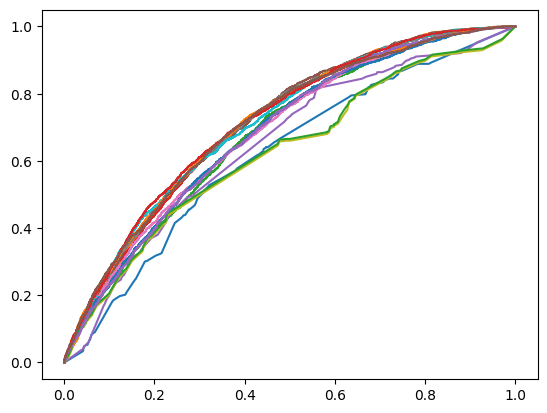

In [70]:

df = pd.read_csv("ppi.csv") # reading in df
df = df[df["sequence"]!= 'X'] # Removing the spooky amino-acid x
# we just need the list of proteins for this testproteins variable
test_size = 50
testproteins = random.sample(list(df["uniprot_id"].unique()),test_size)

results = pd.concat([ppi_prepoc(testproteins,"under_sampling",False)[0],
                     ppi_prepoc(testproteins,'under_sampling',True)[0],
                     ppi_prepoc(testproteins,'No',False)[0],
                     ppi_prepoc(testproteins,'No',True)[0]
                     

                     ],axis=0)

results

In [71]:
results.sort_values("f1",ascending=False)

,Model,f1,accuracy,auc,balancing,Extra_feature
1,RandomForest,0.3232,0.660,0.711396,under_sampling,False
3,MLP,0.3186,0.646,0.712585,under_sampling,True
1,RandomForest,0.3184,0.643,0.712267,under_sampling,True
3,MLP,0.3175,0.619,0.706668,under_sampling,False
2,XGB,0.3005,0.683,0.686202,under_sampling,True
2,XGB,0.2926,0.667,0.681856,under_sampling,False
0,DecisionTree,0.2795,0.538,0.648229,under_sampling,True
0,DecisionTree,0.2762,0.644,0.617159,under_sampling,False
0,DecisionTree,0.1281,0.861,0.626991,No,True
0,DecisionTree,0.1195,0.860,0.621983,No,False


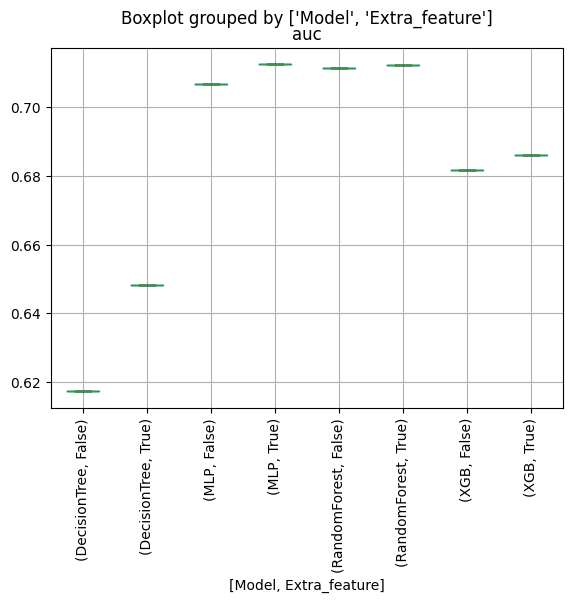

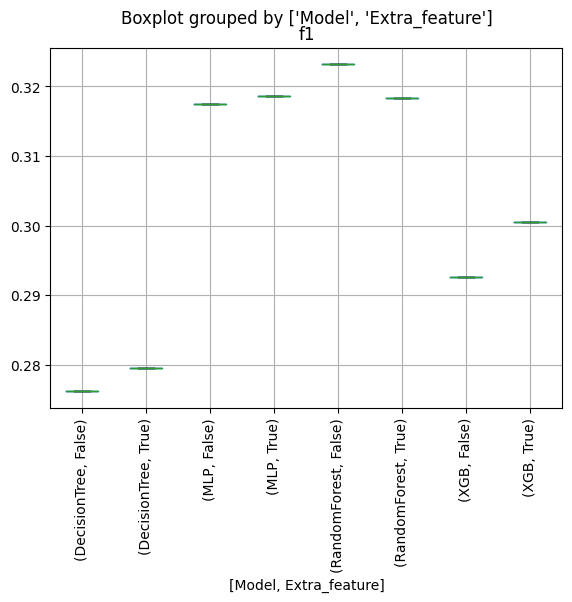

In [72]:
results[results["balancing"]=="under_sampling"].boxplot(column="auc",by=["Model","Extra_feature"])
plt.xticks(rotation=90)
plt.show()
results[results["balancing"]=="under_sampling"].boxplot(column="f1",by=["Model","Extra_feature"])
plt.xticks(rotation=90)
plt.show()



C:\Users\maxvV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


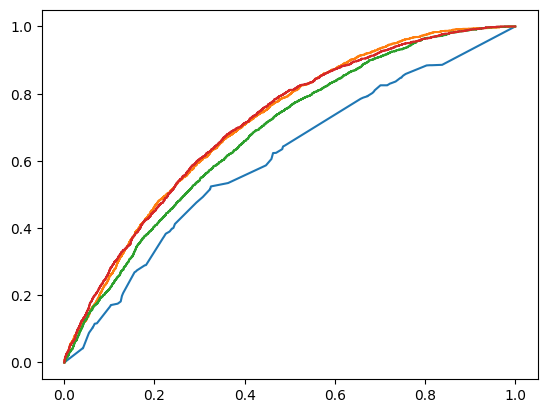

In [73]:
results,models,x_test,y_test = ppi_prepoc(testproteins,'under_sampling',True)

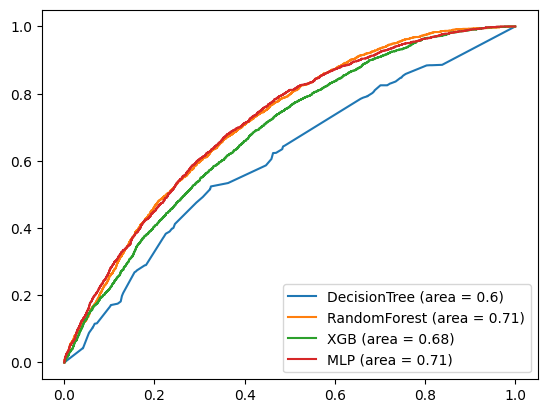

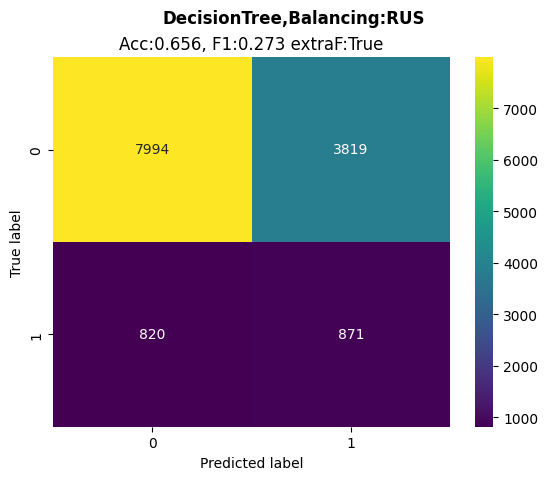

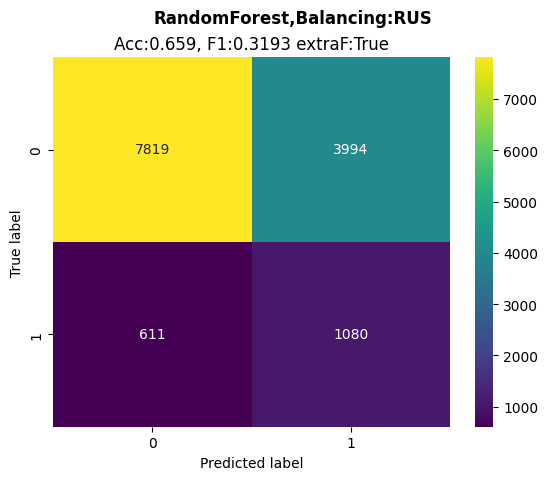

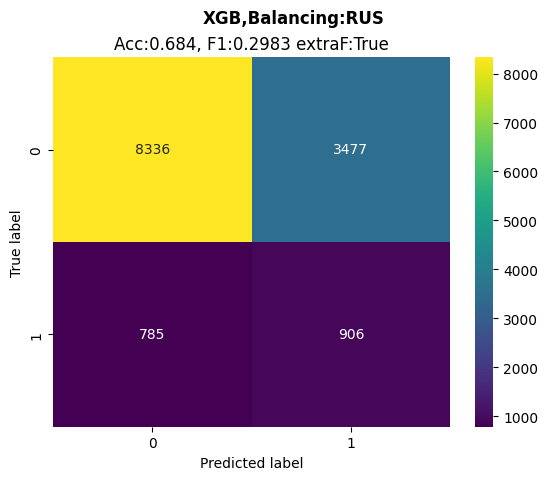

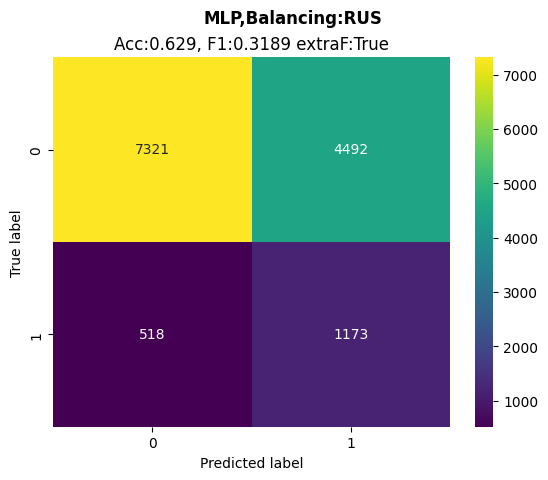

In [74]:

for model in models:
    name = model.__str__().split('Class')[0]
    y_pred_prob  = model.predict_proba(x_test)
    curve  = roc_curve(y_test, y_pred_prob[:, 1])
    auc_  = auc(curve[0], curve[1])
    plt.plot(curve[0], curve[1], label=f'{name} (area = {round(auc_,2)})')
    plt.legend()
plt.show()
for model in models:
        name = model.__str__().split('Class')[0]
        y_pred = model.predict(x_test)
        f1 = round(f1_score(y_test, y_pred),4)
        acc = round(accuracy_score(y_test,y_pred),3)
        if True:
            sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="viridis",fmt="")
            plt.suptitle(f"{name},Balancing:RUS",fontweight='bold')
            plt.title(f"Acc:{acc}, F1:{f1} extraF:True")
            plt.xlabel("Predicted label")
            plt.ylabel("True label");
            plt.show()